Locating Laser Reflection Points

In [114]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

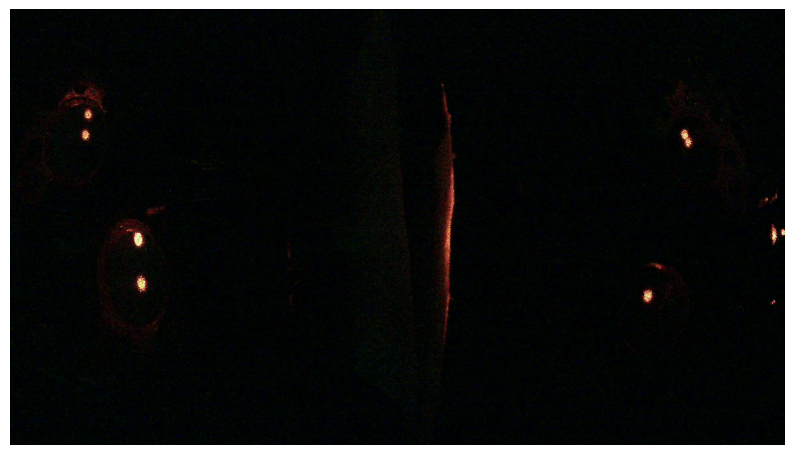

In [4]:
img_bgr = cv2.imread("laser_reflec.jpg")
if img_bgr is None:
    raise FileNotFoundError("Could not read image path")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,7))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [154]:
def pca_elongation(points_xy):
    """
    points_xy: (N,2) array of [x,y] in patch coords.
    returns (ratio, major_sigma, minor_sigma, angle_rad)
    """
    pts = points_xy.astype(float)
    pts -= pts.mean(axis=0, keepdims=True)

    C = np.cov(pts.T)
    vals, vecs = np.linalg.eigh(C)          # vals sorted ascending
    minor, major = np.sqrt(vals[0] + 1e-9), np.sqrt(vals[1] + 1e-9)
    ratio = major / minor
    angle = np.arctan2(vecs[1,1], vecs[0,1])  # direction of major axis
    return ratio, major, minor, angle


def split_cluster_k2(points_xy, n_iter=20):
    """
    Very small k-means for k=2 on points_xy.
    Returns centers (2,2) in patch coords.
    """
    pts = points_xy.astype(float)

    # init: pick two farthest points (good for peanuts)
    d2 = ((pts[:,None,:] - pts[None,:,:])**2).sum(axis=2)
    i, j = np.unravel_index(np.argmax(d2), d2.shape)
    c1, c2 = pts[i].copy(), pts[j].copy()

    for _ in range(n_iter):
        d1 = ((pts - c1)**2).sum(axis=1)
        d2 = ((pts - c2)**2).sum(axis=1)
        m1 = d1 <= d2
        m2 = ~m1
        if m1.sum() == 0 or m2.sum() == 0:
            break
        new_c1 = pts[m1].mean(axis=0)
        new_c2 = pts[m2].mean(axis=0)
        if np.allclose(new_c1, c1) and np.allclose(new_c2, c2):
            break
        c1, c2 = new_c1, new_c2

    return np.vstack([c1, c2])

In [128]:
def postprocess_split_peanuts(clusters, radius_split=18.0, elong_split=1.8, min_sep=6.0):
    """
    Splits clusters that look like two touching spots.
    Returns a new cluster list (some clusters replaced by two subclusters).
    """
    new_clusters = []
    next_label = 1000  # labels for split children

    for c in clusters:
        pts = np.array(c["points"], dtype=float)   # patch coords [x,y]
        if len(pts) < 20:
            new_clusters.append(c)
            continue

        ratio, major, minor, _ = pca_elongation(pts)

        # decide whether to split
        if (c["radius"] > radius_split) or (ratio > elong_split):
            centers2 = split_cluster_k2(pts)

            # reject split if the two centers are basically on top of each other
            if np.linalg.norm(centers2[0] - centers2[1]) < min_sep:
                new_clusters.append(c)
                continue

            # build two child clusters based on assignment
            d1 = ((pts - centers2[0])**2).sum(axis=1)
            d2 = ((pts - centers2[1])**2).sum(axis=1)
            m1 = d1 <= d2
            m2 = ~m1

            for m, center in [(m1, centers2[0]), (m2, centers2[1])]:
                sub_pts = pts[m]
                if len(sub_pts) < 5:
                    continue
                dist = np.linalg.norm(sub_pts - center, axis=1)
                radius = float(dist.max())
                x_min, y_min = np.min(sub_pts, axis=0)
                x_max, y_max = np.max(sub_pts, axis=0)

                new_clusters.append({
                    **c,
                    "label": int(next_label),
                    "center": center.tolist(),
                    "radius": radius,
                    "size": int(len(sub_pts)),
                    "points": sub_pts.tolist(),
                    "bbox": [float(x_min), float(x_max), float(y_min), float(y_max)],
                    "density": float(len(sub_pts) / (np.pi * radius**2)) if radius > 0 else 0.0,
                    "was_split": True,
                })
                next_label += 1
        else:
            new_clusters.append(c)

    # sort biggest first like you already do
    new_clusters.sort(key=lambda x: x["size"], reverse=True)
    return new_clusters

In [138]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import cv2

THRESHOLD = 200

def find_clusters_with_circles(patch, threshold=200, eps=5.0, min_samples=5, show=True, title=""):
    y_coords, x_coords = np.where(patch > threshold)

    if len(x_coords) == 0:
        if show:
            print("No points above threshold!")
        return []

    coordinates = np.column_stack([x_coords, y_coords])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(coordinates)

    unique_labels = set(labels)
    clusters = []

    for label in unique_labels:
        if label == -1:
            continue
        mask = labels == label
        cluster_points = coordinates[mask]

        center = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - center, axis=1)
        radius = np.max(distances)

        x_min, y_min = np.min(cluster_points, axis=0)
        x_max, y_max = np.max(cluster_points, axis=0)

        clusters.append({
            'label': int(label),
            'center': center.tolist(),      # [x, y] in PATCH coords
            'radius': float(radius),
            'size': int(len(cluster_points)),
            'points': cluster_points.tolist(),
            'bbox': [float(x_min), float(x_max), float(y_min), float(y_max)],
            'density': float(len(cluster_points) / (np.pi * radius**2)) if radius > 0 else 0.0
        })

    clusters.sort(key=lambda x: x['size'], reverse=True)

    clusters = postprocess_split_peanuts(clusters, radius_split=20.0, elong_split=2, min_sep=8.0)

    if show:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        axes[0].imshow(patch, cmap='gray')
        colors = plt.cm.tab10(np.linspace(0, 1, max(len(clusters), 1)))

        for i, cluster in enumerate(clusters):
            color = colors[i]
            center = cluster['center']
            radius = cluster['radius']

            circle = plt.Circle(center, radius, color=color, fill=False, linewidth=2, alpha=0.7)
            axes[0].add_patch(circle)
            axes[0].scatter(center[0], center[1], color=color, s=100, marker='x', linewidths=2)
            axes[0].text(center[0], center[1], f'C{i}', color='white', fontsize=12, fontweight='bold',
                         ha='center', va='center',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        axes[0].set_title(title or f'Found {len(clusters)} Cluster(s)')
        axes[0].axis('equal')

        axes[1].axis('off')
        if clusters:
            summary = "CLUSTER CENTERS:\n\n"
            for i, cluster in enumerate(clusters):
                summary += f"Cluster {i} (Label {cluster['label']}):\n"
                summary += f"  Center: ({cluster['center'][0]:.1f}, {cluster['center'][1]:.1f})\n"
                summary += f"  Radius: {cluster['radius']:.1f} px\n"
                summary += f"  Size: {cluster['size']} points\n"
                summary += f"  Density: {cluster['density']:.3f} pts/px²\n"
                summary += f"  BBox: [{cluster['bbox'][0]:.0f}-{cluster['bbox'][1]:.0f}, {cluster['bbox'][2]:.0f}-{cluster['bbox'][3]:.0f}]\n\n"
            axes[1].text(0.05, 0.95, summary, fontfamily='monospace',
                         verticalalignment='top', fontsize=10)

        plt.tight_layout()
        plt.show()

    return clusters


def clusters_in_roi(gray, roi, threshold=200, eps=5.0, min_samples=5, show=True):
    x1, y1, x2, y2 = roi
    patch = gray[y1:y2, x1:x2]

    clusters = find_clusters_with_circles(
        patch, threshold=threshold, eps=eps, min_samples=min_samples,
        show=show, title=f"ROI {roi} | threshold={threshold}, eps={eps}"
    )

    # Add full-image centers to each cluster dict
    for c in clusters:
        cx, cy = c["center"]  # patch coords
        c["center_full"] = [cx + x1, cy + y1]

    return clusters


==================== M1 ====================


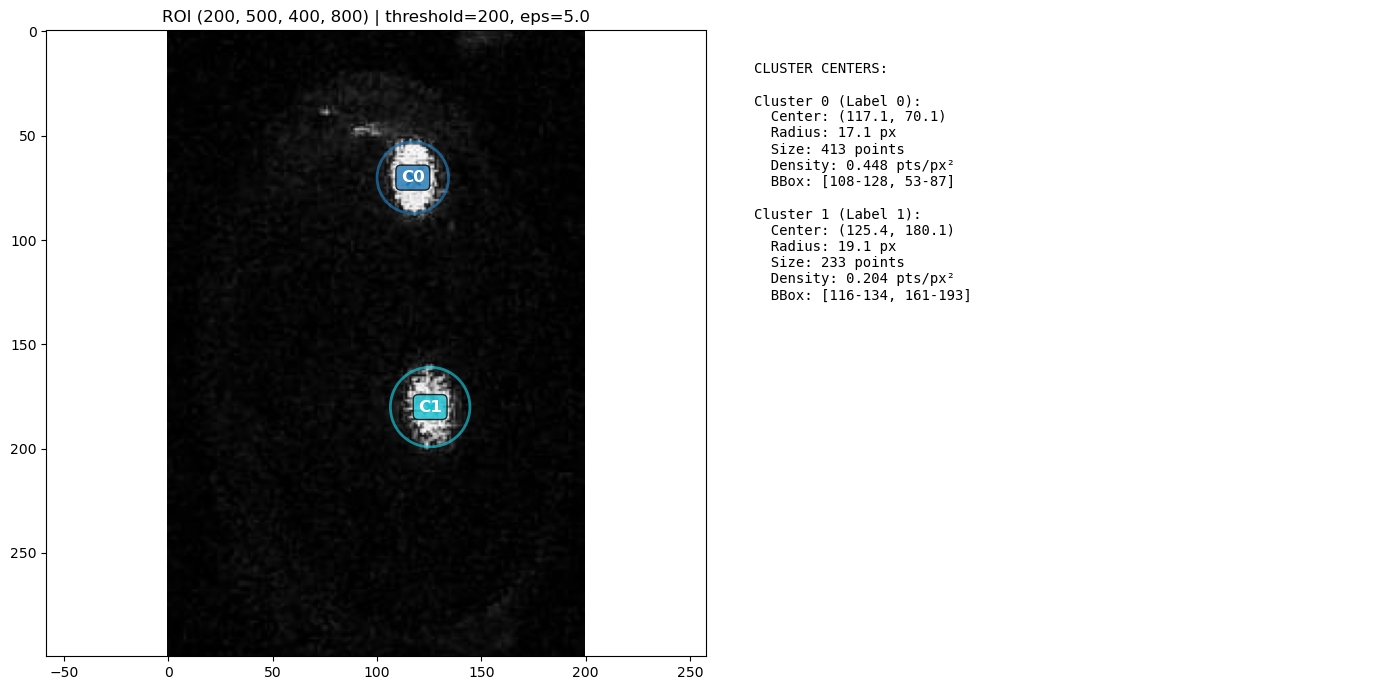

Full-image centers:
  M1 cluster 0: (317.1, 570.1)
  M1 cluster 1: (325.4, 680.1)

==================== M2 ====================


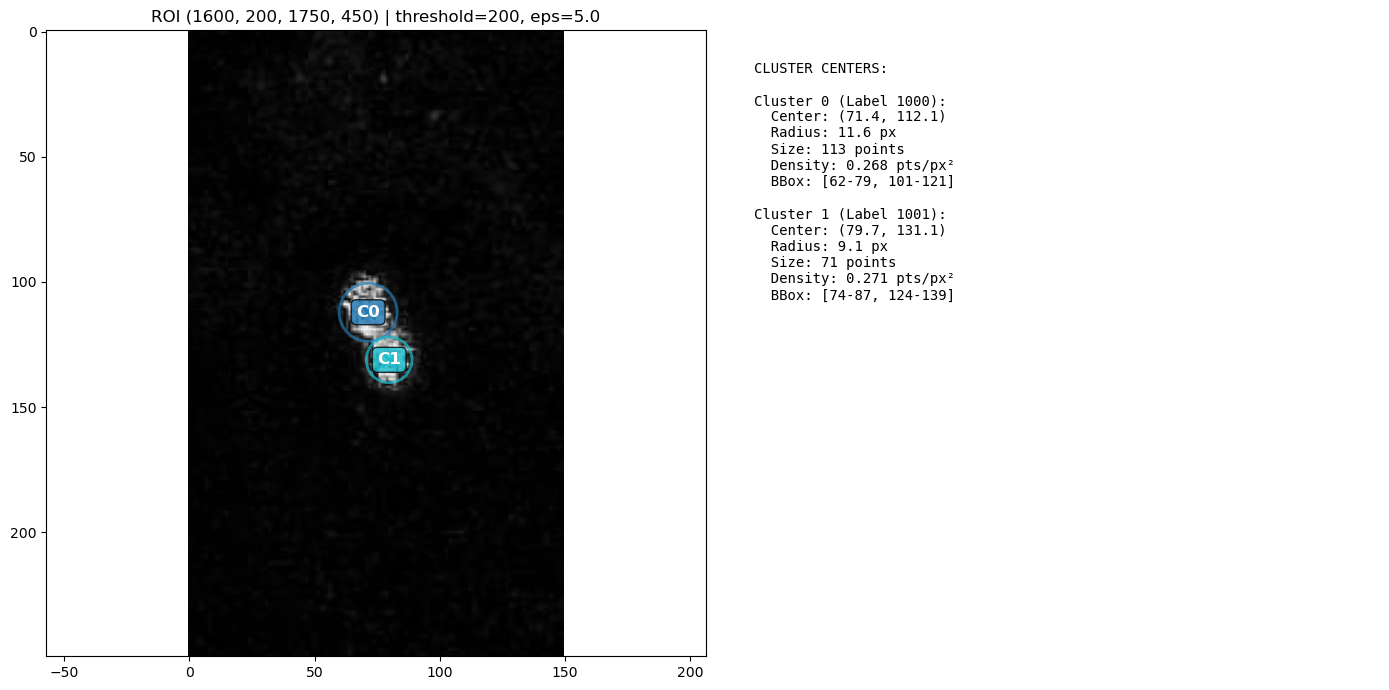

Full-image centers:
  M2 cluster 0: (1671.4, 312.1)
  M2 cluster 1: (1679.7, 331.1)

==================== M3 ====================


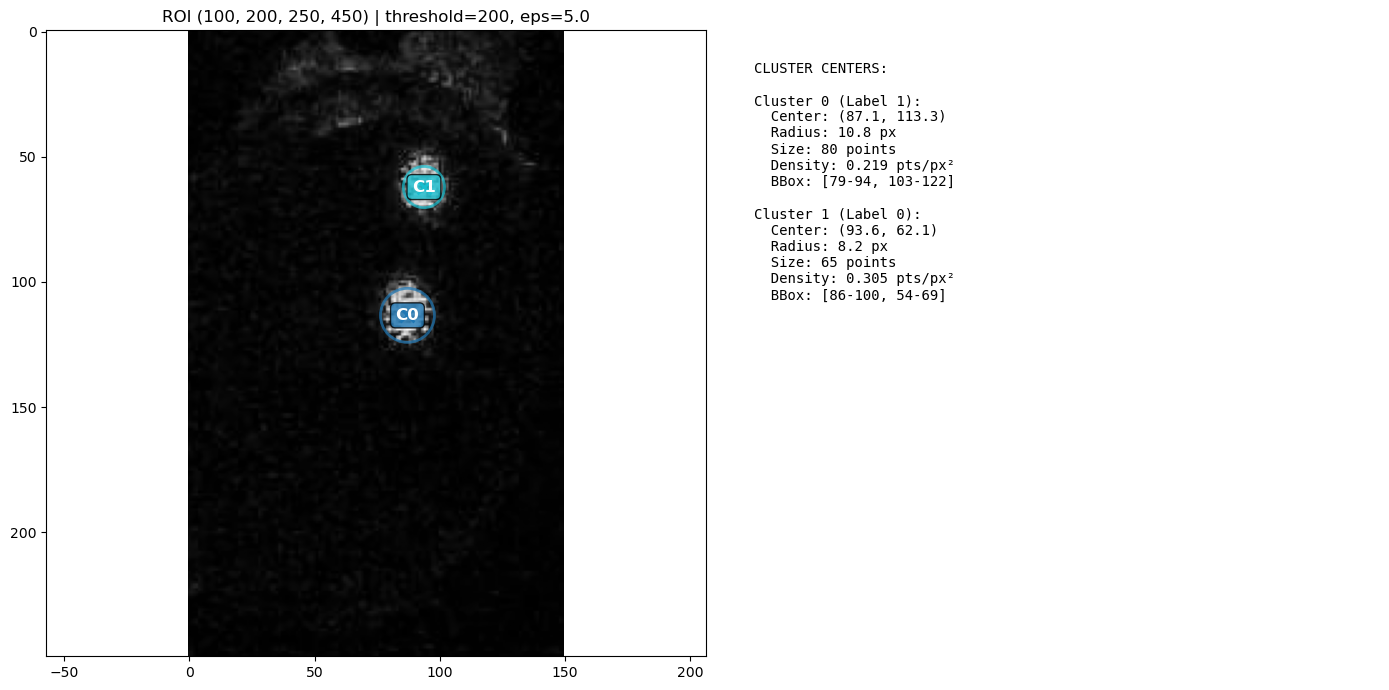

Full-image centers:
  M3 cluster 0: (187.1, 313.3)
  M3 cluster 1: (193.6, 262.1)

==================== M4 ====================


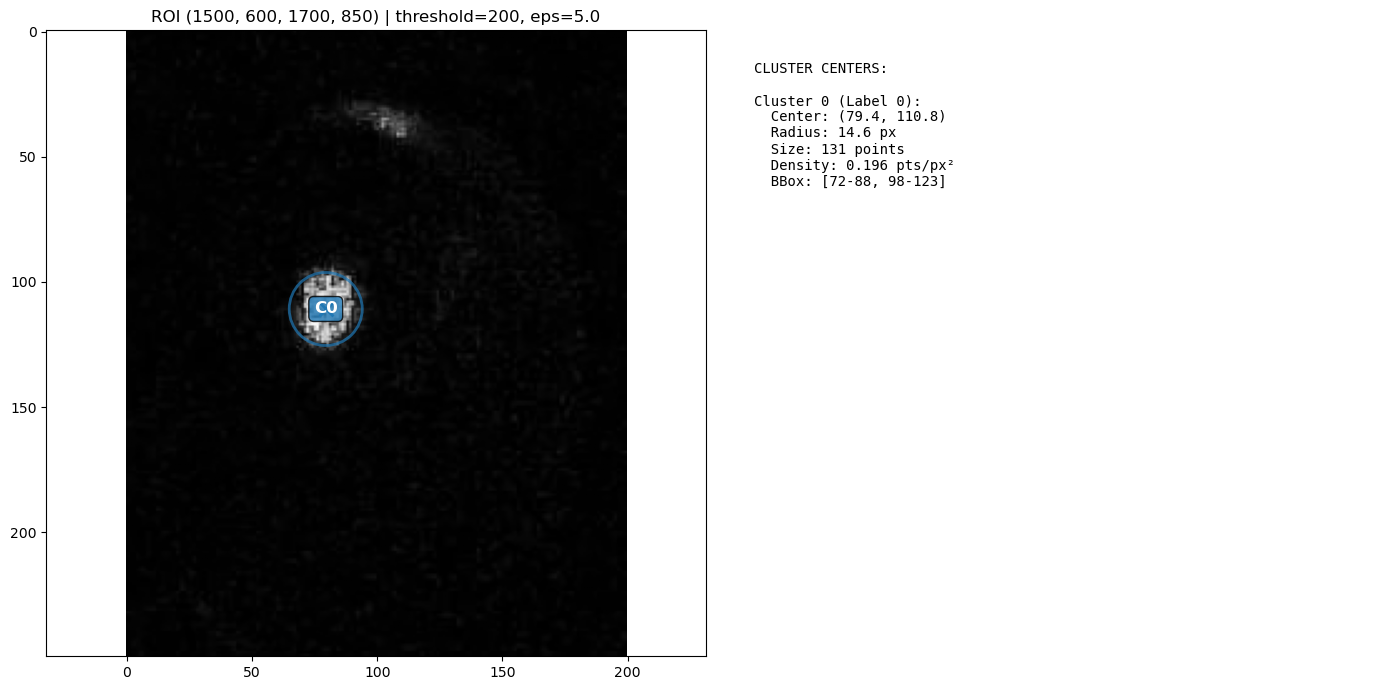

Full-image centers:
  M4 cluster 0: (1579.4, 710.8)


In [140]:
# Build grayscale once
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

rois = {
    "M1": (200, 500, 400, 800),
    "M2": (1600, 200, 1750, 450),
    "M3": (100, 200, 250, 450),
    "M4": (1500, 600, 1700, 850),
}

all_clusters = {}
for name, roi in rois.items():
    print("\n====================", name, "====================")
    clusters = clusters_in_roi(gray, roi, threshold=THRESHOLD, eps=5.0, min_samples=5, show=True)
    all_clusters[name] = clusters

    print("Full-image centers:")
    for i, c in enumerate(clusters):
        cx, cy = c["center_full"]
        print(f"  {name} cluster {i}: ({cx:.1f}, {cy:.1f})")

In [150]:
laser_centers = []

for mirror, clusters in all_clusters.items():
    for c in clusters:
        x_px, y_px = c["center_full"]
        laser_centers.append((mirror, x_px, y_px))

In [152]:
laser_centers

[('M1', 317.1428571428571, 570.0992736077482),
 ('M1', 325.44206008583694, 680.0557939914163),
 ('M2', 1671.353982300885, 312.08849557522126),
 ('M2', 1679.7464788732395, 331.09859154929575),
 ('M3', 187.0625, 313.3375),
 ('M3', 193.63076923076923, 262.0923076923077),
 ('M4', 1579.4198473282443, 710.793893129771)]